# Integrating PPI data to identify OPC-endothelial cell interactors

In [1]:
import urllib
import os
import json

import pandas
import numpy
import networkx

%matplotlib inline

## Download STRING if missing

In [2]:
url_to_path = {
    # STRING PPI
    'http://string.embl.de/newstring_download/protein.aliases.v10/10090.protein.aliases.v10.txt.gz':
        os.path.join('download', 'string', '10090.protein.aliases.v10.txt.gz'),
    'http://string.embl.de/newstring_download/protein.links.v10/10090.protein.links.v10.txt.gz':
        os.path.join('download', 'string', '10090.protein.links.v10.txt.gz'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

## Read and prepare STRING

In [3]:
path = os.path.join('download', 'string', '10090.protein.aliases.v10.txt.gz')
alias_df = pandas.read_table(path, skiprows=1, names = ['string_protein_id', 'alias', 'source'])

In [4]:
alias_df = alias_df.query("source == 'BLAST_KEGG_NAME BLAST_UniProt_GN Ensembl_EntrezGene Ensembl_IKMCs_ES_cells_available Ensembl_MGI Ensembl_UniProt_GN Ensembl_WikiGene'")
alias_df = alias_df[['string_protein_id', 'alias']]

In [5]:
path = os.path.join('download', 'string', '10090.protein.links.v10.txt.gz')
string_df = pandas.read_table(path, sep=' ')

string_df = string_df.merge(
    alias_df.rename(columns={'string_protein_id': 'protein1', 'alias': 'opc_candidate'})).merge(
    alias_df.rename(columns={'string_protein_id': 'protein2', 'alias': 'endo_candidate'}))

string_df = string_df[['opc_candidate', 'endo_candidate', 'combined_score']].drop_duplicates()
string_df = string_df.sort_values(['opc_candidate', 'endo_candidate'])
string_df.head(2)

,opc_candidate,endo_candidate,combined_score
3478100,0610007P14Rik,2610028H24Rik,648
3849791,0610007P14Rik,Aacs,153


In [6]:
len(string_df)

4556514

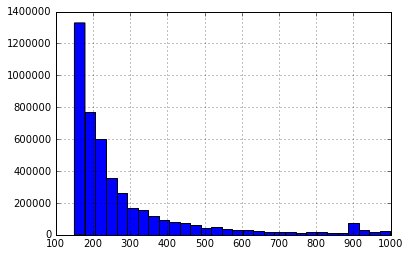

In [7]:
string_df.combined_score.hist(bins=30);

## Integrate expression data

In [8]:
fc_df = pandas.read_table('data/enrichment.tsv')
fc_df['opc_microglia_ratio'] = fc_df['Oligodendrocyte Precursor Cell'] / fc_df['Microglia']
fc_df = fc_df[['Gene symbol', 'opc_L2FC', 'opc_microglia_ratio', 'endothelial_L2FC', 'DA_Cat_L2FC']]
fc_df.head(2)

,Gene symbol,opc_L2FC,opc_microglia_ratio,endothelial_L2FC,DA_Cat_L2FC
0,0610005C13Rik,0.00000,1.000000,-0.11760,NaN
1,0610007C21Rik,0.39919,0.798934,0.11792,NaN


In [9]:
get_renamer = lambda x: {
    'Gene symbol': x,
    'opc_L2FC': '{}_opc_l2fc'.format(x),
    'opc_microglia_ratio': '{}_opc_microglia_ratio'.format(x),
    'endothelial_L2FC': '{}_endo_l2fc'.format(x),
    'DA_Cat_L2FC': '{}_dac_l2fc'.format(x),
}

ixn_df = string_df.merge(
    fc_df.rename(columns=get_renamer('opc_candidate'))).merge(
    fc_df.rename(columns=get_renamer('endo_candidate')))

ixn_df = ixn_df.sort_values(['opc_candidate', 'endo_candidate'])

len(ixn_df)

4430882

In [10]:
ixn_df.head(2)

,opc_candidate,endo_candidate,combined_score,opc_candidate_opc_l2fc,opc_candidate_opc_microglia_ratio,opc_candidate_endo_l2fc,opc_candidate_dac_l2fc,endo_candidate_opc_l2fc,endo_candidate_opc_microglia_ratio,endo_candidate_endo_l2fc,endo_candidate_dac_l2fc
0,0610007P14Rik,2610028H24Rik,648,-0.23887,5.232446,-2.0939,NaN,0.0000,1.000000,3.203400e-16,NaN
47,0610007P14Rik,Aacs,153,-0.23887,5.232446,-2.0939,NaN,-2.4177,1.798442,-3.773100e+00,NaN


## Read GO Annotations

In [11]:
with open('data/go-to-genes.json') as fp:
    go_to_genes = json.load(fp)

# GO Terms to choose from
list(go_to_genes.keys())

['cell-cell adhesion', 'cell surface']

## Filter for candidate interactions

In [12]:
# Parameters
l2fc_cutoff = 1.5
string_score = 700
opc_microglia_min_ratio = 0.05

In [13]:
opc_go_terms = [
    'cell surface',
    'cell-cell adhesion'
]

endo_go_terms = [
    'cell surface',
    'cell-cell adhesion'
]

opc_go_subset = set.intersection(*[set(go_to_genes[term]) for term in opc_go_terms])
endo_go_subset = set.intersection(*[set(go_to_genes[term]) for term in endo_go_terms])

len(opc_go_subset), len(endo_go_subset)

(140, 140)

In [14]:
# Save parameters
param_df = pandas.DataFrame({
    'parameter': ['log2_fold_change_cutoff', 'opc_microglia_min_ratio', 'string_score_cutoff', 'opc_GO_terms', 'endo_GO_terms'],
    'value': [l2fc_cutoff, opc_microglia_min_ratio, string_score, opc_go_terms, endo_go_terms]})

In [15]:
filtered_df = ixn_df.copy()

# Filter interactions based on STRING score
filtered_df = filtered_df.query("combined_score >= @string_score")

# Filter for OPC candidates that are enriched in expression in OPCs
filtered_df = filtered_df.query("opc_candidate_opc_l2fc >= @l2fc_cutoff and opc_candidate_opc_microglia_ratio > @opc_microglia_min_ratio")

# Filter for endothelial candidates that are enriched in expression in endothelial cells
filtered_df = filtered_df.query("endo_candidate_endo_l2fc >= @l2fc_cutoff")

# Filter for OPC candidates by GO term membership
filtered_df = filtered_df.query("opc_candidate in @opc_go_subset")

# Filter for endothelial candidates by GO term membership
filtered_df = filtered_df.query("endo_candidate in @endo_go_subset")

len(filtered_df)

29

In [16]:
filtered_df.head()

,opc_candidate,endo_candidate,combined_score,opc_candidate_opc_l2fc,opc_candidate_opc_microglia_ratio,opc_candidate_endo_l2fc,opc_candidate_dac_l2fc,endo_candidate_opc_l2fc,endo_candidate_opc_microglia_ratio,endo_candidate_endo_l2fc,endo_candidate_dac_l2fc
2812820,Alcam,Itgb1,858,5.5683,174.060237,-3.5519,NaN,1.0750,1.570693,2.3607,NaN
4342010,Anxa1,Cxcr4,903,2.6875,0.617111,5.4665,NaN,1.1729,0.468453,2.7818,1.1388
1180048,Anxa1,Il6,705,2.6875,0.617111,5.4665,NaN,0.0000,0.879275,2.4959,NaN
1102123,Cd1d1,B2m,993,2.0542,0.385555,1.4210,NaN,2.7299,0.132059,1.6164,NaN
3443688,Cxcl12,Anxa1,901,1.5265,7.270368,1.4406,NaN,2.6875,0.617111,5.4665,NaN


In [17]:
# Genes with the most OPC candidate interactions
opc_count_df = filtered_df.opc_candidate.value_counts().reset_index()
opc_count_df.columns = ['gene', 'interactions']
opc_count_df.head(4)

,gene,interactions
0,Ptprc,6
1,Cxcl12,4
2,Vcam1,3
3,Anxa1,2


In [18]:
# Genes with the most endothelial candidate interactions
endo_count_df = filtered_df.endo_candidate.value_counts().reset_index()
endo_count_df.columns = ['gene', 'interactions']
endo_count_df.head(4)

,gene,interactions
0,Itgb1,9
1,Il6,5
2,Itga4,4
3,B2m,3


In [19]:
# Genes with interactions
genes = set(filtered_df.opc_candidate) | set(filtered_df.endo_candidate)
len(genes)

23

In [20]:
# Save to excel
path = os.path.join('data', 'filtered.xlsx')
writer = pandas.ExcelWriter(path, engine='xlsxwriter')
filtered_df.to_excel(writer, index=False, sheet_name='interactions')
opc_count_df.to_excel(writer, index=False, sheet_name='opc_candidate_gene_counts')
endo_count_df.to_excel(writer, index=False, sheet_name='endo_candidate_gene_counts')
param_df.to_excel(writer, index=False, sheet_name='parameters')
for sheet in writer.sheets.values():
    sheet.freeze_panes(1, 0)
writer.close()

## Network

In [21]:
graph = networkx.DiGraph()
for i, row in fc_df.iterrows():
    gene = row['Gene symbol']
    if not gene in genes:
        continue
    graph.add_node(gene,
                   opc_l2fc = row['opc_L2FC'],
                   endo_l2fc = row['endothelial_L2FC'],
                   dac_l2fc = row['DA_Cat_L2FC'])
for i, row in filtered_df.iterrows():
    graph.add_edge(row.opc_candidate, row.endo_candidate, weight=row.combined_score)

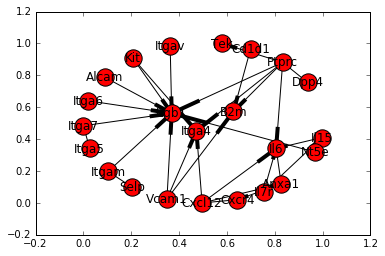

In [22]:
pos = networkx.spring_layout(graph, weight='weight', iterations=500, k=2)
pc = networkx.draw_networkx_nodes(graph, pos)
pc = networkx.draw_networkx_edges(graph, pos)
labels = networkx.draw_networkx_labels(graph, pos)

In [23]:
# Save network
path = os.path.join('data', 'network.graphml')
networkx.readwrite.write_graphml(graph, path)